In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class Twiss:
    def __init__(self, alpha: float, beta: float, emit: float):
        self.alpha = alpha
        self.beta = beta
        self.emit = emit
        
    def __str__(self):
        return f'alpha = {self.alpha}\nbeta = {self.beta}\nemit = {self.emit}\n'
    
    def rms_space(self):
        return np.sqrt(self.emit*self.beta)
    
    def rms_angle_waist(self):
        return np.sqrt(self.emit/self.beta)
    
    def gamma(self):
        return (1+self.alpha**2)/self.beta

In [3]:
def ellipse_twiss(twiss_paramters: Twiss, num_points: int = 1000):
    # rmsX = np.sqrt(twiss_paramters.emit/twiss_paramters.beta);
    # rmsTheta = np.sqrt(twiss_paramters.emit*twiss_paramters.beta);
    rmsX = twiss_paramters.rms_space();
    rmsTheta = twiss_paramters.rms_angle_waist();
    
    m = -twiss_paramters.alpha/twiss_paramters.beta
    b = rmsTheta
    a = rmsX
    t = np.linspace(0,2*np.pi,num_points)
    x = a*np.cos(t)
    y = b*np.sin(t)
    x = x.transpose()
    y = y.transpose()
    y = y + x*m
    
    return x,y

In [4]:
def twiss_to_cov_mat(twiss: Twiss):
    
    sigma = np.array([[twiss.beta,-twiss.alpha],[-twiss.alpha,twiss.gamma]])
    
    return twiss.emit*sigma 
    
def twiss_to_cov_mat_2d(twiss_x: Twiss,twiss_y: Twiss):
    cov_mat_x = twiss_to_cov_mat(twiss_x) 
    cov_mat_y = twiss_to_cov_mat(twiss_y) 

    return np.block([[cov_mat_x,np.zeros([2,2])],
                     [np.zeros([2,2]),cov_mat_y]])

In [5]:
twiss_x = Twiss(alpha=2,beta=5,emit=1e-8)
twiss_y = Twiss(alpha=2,beta=5,emit=1e-8)

cov_mat = twiss_to_cov_mat_2d(twiss_x,twiss_y)
mean_val = [0,0,0,0]

In [6]:
twiss_x.rms_space()

0.00022360679774997898

In [7]:
vals = np.random.multivariate_normal(mean_val,cov_mat,10000)
vals.shape

(10000, 4)

In [8]:
x_ell_x,y_ell_x = ellipse_twiss(twiss_x)

0.00022360679774997898
4.4721359549995795e-05
-0.4


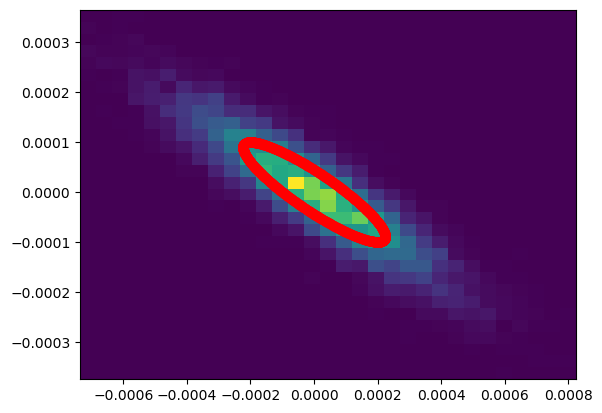

In [9]:
plt.hist2d(x=vals[:,0],y=vals[:,1],bins=31);
plt.scatter(x_ell_x,y_ell_x,color='red')

In [10]:
x_ell_y,y_ell_y = ellipse_twiss(twiss_y)

0.00022360679774997898
4.4721359549995795e-05
-0.4


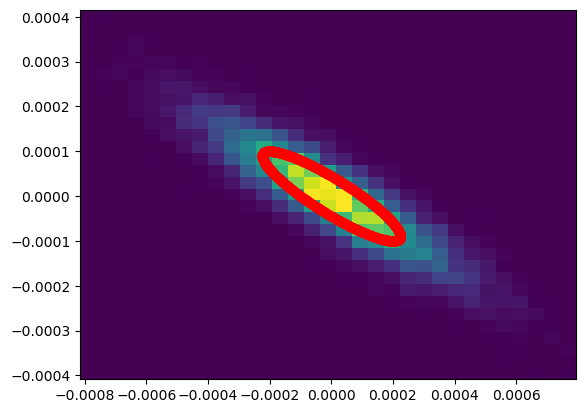

In [11]:
plt.hist2d(x=vals[:,2],y=vals[:,3],bins=31);
plt.scatter(x_ell_y,y_ell_y,color='red')

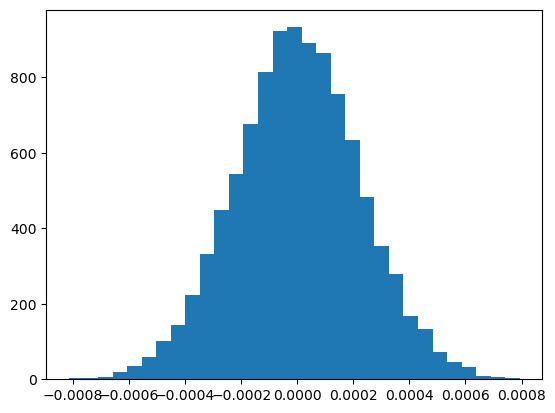

In [12]:
plt.hist(vals[:,2],bins=31);

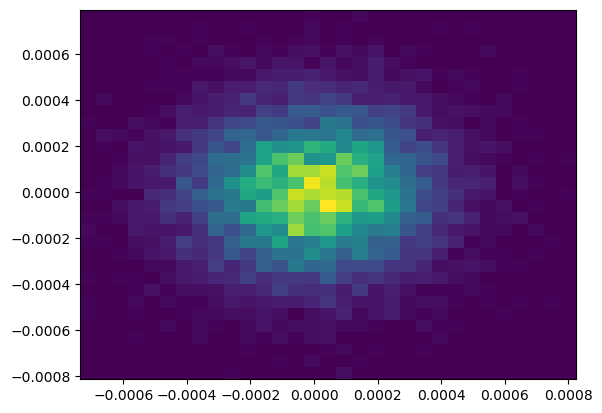

In [13]:
plt.hist2d(x=vals[:,0],y=vals[:,2],bins=31);

In [14]:
vals.std(axis=0)

array([2.24287294e-04, 1.00111628e-04, 2.24603942e-04, 9.99277872e-05])

# Transform Psuedo-Random Distribution

In [15]:
from scipy.stats.qmc import Halton,Sobol
from scipy.stats import norm

from typing import Callable

In [16]:
def gen_halton_gaussian_4d(twiss_x,twiss_y,num,seed=1,dim=4,loc=[0,0,0,0]):
    rmsX = twiss_x.rms_space();
    rmsThetaX = twiss_x.rms_angle_waist();
    rmsY = twiss_y.rms_space();
    rmsThetaY = twiss_y.rms_angle_waist();    
    
    a=Halton(d=dim,seed=seed)
    vals = a.random(n=num)
    
    dist = norm.ppf(vals,loc=loc,scale=[rmsX,rmsThetaX,rmsY,rmsThetaY])

    mx = -twiss_x.alpha/twiss_x.beta
    my = -twiss_y.alpha/twiss_y.beta;
    
    dist[:,1] += dist[:,0]*mx
    dist[:,3] += dist[:,2]*my
    
    return dist

In [43]:
%%timeit -n 10
norm_dist_tf = gen_halton_gaussian_4d(twiss_x,twiss_y,num=1000)

2.56 ms ± 235 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


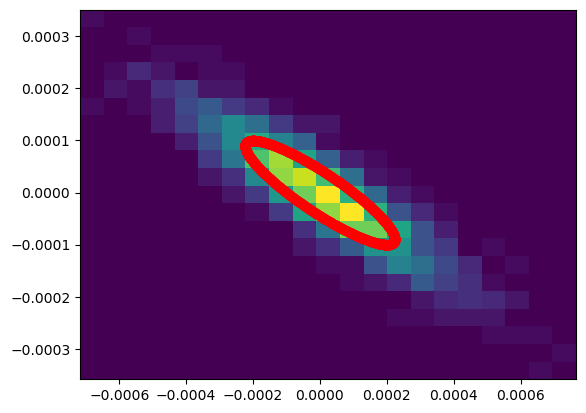

In [23]:
plt.hist2d(x=norm_dist_tf[:,0],y=norm_dist_tf[:,1],bins=21);
plt.scatter(x_ell_x,y_ell_x,color='red')

In [24]:
def gen_dist_normal_coord_4d(func: Callable,**kwarg):
    twiss_x = Twiss(alpha=0,beta=1,emit=1)
    twiss_y = Twiss(alpha=0,beta=1,emit=1)
    return func(twiss_x,twiss_y,**kwarg)

In [40]:
def transform_norm_dist(a: np.ndarray,twiss_x: Twiss,twiss_y: Twiss):
       
    a_copy = a.copy()
    
    twiss_old  = Twiss(alpha=0,beta=1,emit=1)
    
    x_scale = twiss_x.rms_space()/twiss_old.rms_space();
    x_theta_scale = twiss_x.rms_angle_waist()/twiss_old.rms_angle_waist();
    y_scale = twiss_y.rms_space()/twiss_old.rms_space();
    y_theta_scale = twiss_y.rms_angle_waist()/twiss_old.rms_angle_waist();  
    
    mx = -twiss_x.alpha/twiss_x.beta
    my = -twiss_y.alpha/twiss_y.beta;
    
    a_copy[:,0] *= x_scale
    a_copy[:,1] *= x_theta_scale
    a_copy[:,2] *= y_scale
    a_copy[:,3] *= y_theta_scale
    
    a_copy[:,1] += a_copy[:,0]*mx
    a_copy[:,3] += a_copy[:,2]*my
    
    return a_copy

In [42]:
%%timeit -n 10
norm_dist = gen_dist_normal_coord_4d(gen_halton_gaussian_4d,num=1000)

2.81 ms ± 380 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
%%timeit -n 10
norm_dist_tf = transform_norm_dist(norm_dist,twiss_x,twiss_y)

58.4 µs ± 4.55 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
# norm_dist_tf = gen_halton_gaussian_4d(twiss_x,twiss_y,num=1000)

In [36]:
print(twiss_x)

alpha = 2
beta = 5
emit = 1e-08



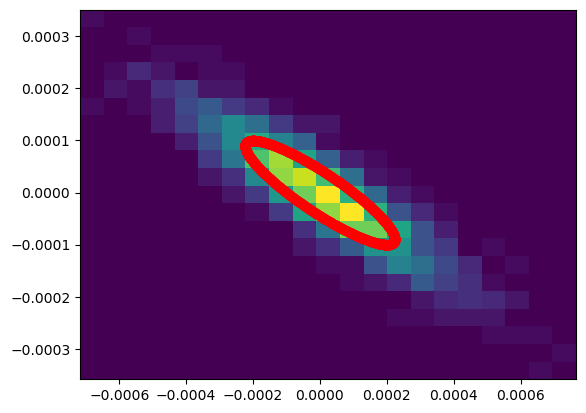

In [38]:
plt.hist2d(x=norm_dist_tf[:,0],y=norm_dist_tf[:,1],bins=21);
plt.scatter(x_ell_x,y_ell_x,color='red')

In [ ]:
print(twiss_x)

In [ ]:
new = norm_dist_tf.std(axis=0)
new